In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Funzione per la discesa del gradiente
- alpha => learning rate
- tolerance => ciò che ci permette di fermarci quando non ci sono più miglioramenti significativi nella funzione di costo
- theta => parametri da apprendere
- x => features
- y => target
- m => numero di esempi

In [134]:
def gradientDescent(alpha, tolerance, theta, x, y, m):
    
    previousCost = 1000000000000000
    while True:
        h = np.dot(x, theta) # ipotesi, ovvero i valori predetti
        #Discesa del gradiente
        theta = theta - ((alpha * (1/m)) * np.dot((h - y).T, x).T)
        j_cost = (np.sum((h - y)**2))/(2*m)
        diff = previousCost - j_cost
        if diff < tolerance:
            # se il cambiamento nei theta è stato minimale l'algoritmo si ferma
            break
        else:
            # aggiornamento costo
            previousCost = j_cost

    return theta

Funzione per calcolare le predizioni
- x_test => features del test set
- theta => parametri derivanti dalla fase di training

Esegue una combinazione lineare tra la matrice delle features x_test e il vettore dei pesi theta

In [135]:
def predictions(x_test, theta):
    pred = np.dot(x_test, theta)
    return pred

Funzione per la valutazione
- prediction => predizioni del modello
- target => target del dataset

In [136]:
def modelEvaluation(prediction, target):
    meanTarget = np.mean(target)

    #R2
    sse = np.sum((prediction-target)**2)
    sst = np.sum((target - meanTarget)**2)
    r2 = 1- (sse/sst)

    #Mean absolute error
    mae = np.mean(np.abs(prediction - target))

    #RMSE
    rmse = np.sqrt((np.sum((prediction - target)**2)) / len(prediction))

    return (r2, mae, rmse)

Funzioni di stampa dei risultati

In [137]:
def printLinRegFunction(theta, data):
    print("########## MODELLO ##########")
    print('\nLGND: ' + data.columns.values[len(theta)] + " = Theta * feature")
    print('\n' + data.columns.values[len(theta)] + " = ")
    for i in range(len(theta)):
        print('\t' + str(round(theta[i], 5)) + ' * ' + data.columns.values[i] + ' +')


def printEvaluationResults(r2, mae, rmse):
    print('\n########## RISULTATI VALUTAZIONE ##########')
    print('\nR2 = ' + str(round(r2, 5)))
    print("Mean absolute error = " +str(round(mae, 5)))
    print('Root Mean Squared Error = ' + str(round(rmse, 5)))

### Carico il dataset

In [138]:
dataset = pd.read_csv('cars_numeric.csv')

# è meglio mischaire le righe del dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# bisogna inserire la colonna di bias
dataset.insert(0, 'bias', np.ones(dataset.shape[0]), True)

### Valutazione tramite split 70/30

In [139]:
training_set = dataset.head(round(len(dataset)*(70/100)))
test_set = dataset.tail(len(dataset) - len(training_set)).reset_index(drop=True)

#fase di fit
alpha = 0.1
tolerance = 0.000001
x = training_set.drop('price', axis = 1).values
y = training_set['price'].values
m = len(training_set)

#inizializzazione dei theta
# genero un array di theta casuali inizializzati in base ai valori massimi e minimi dei dati 
# target (y) e in base al numero di features nella matrice delle features (x)
theta = np.random.uniform(-(np.max(y)), np.max(y), size=x.shape[1])

finalTheta = gradientDescent(alpha=alpha, tolerance=tolerance, theta=theta, x=x, y=y, m=m)


#Valutazione
x_test = test_set.drop('price', axis = 1).values
predizione = predictions(x_test, finalTheta)
y_dataset = test_set['price'].values

r2, mae, rmse = modelEvaluation(prediction=predizione, target=y_dataset)

### Stampe & grafici

In [140]:
print("VALUTAZIONE DEL MODELLO TRAMITE SPLIT 70/30")
printLinRegFunction(theta=finalTheta, data=dataset)
printEvaluationResults(r2=r2, mae=mae, rmse=rmse)

VALUTAZIONE DEL MODELLO TRAMITE SPLIT 70/30
########## MODELLO ##########

LGND: price = Theta * feature

price = 
	13394.95214 * bias +
	88.38132 * symboling +
	-226.41427 * normalized-losses +
	-971.12837 * make +
	-2815.86861 * fuel-type +
	907.80329 * aspiration +
	361.29307 * num-of-doors +
	-392.04385 * body-style +
	-190.91468 * drive-wheels +
	1523.97461 * engine-location +
	817.19553 * wheel-base +
	-507.58954 * length +
	594.7819 * width +
	459.08793 * height +
	1449.7789 * curb-weight +
	-254.20866 * engine-type +
	1424.1512 * num-of-cylinders +
	4614.7462 * engine-size +
	-261.19594 * fuel-system +
	303.9117 * bore +
	-799.55702 * stroke +
	3216.12648 * compression-ratio +
	262.64123 * horsepower +
	804.97338 * peak-rpm +
	-1616.27086 * city-mpg +
	1891.74216 * highway-mpg +

########## RISULTATI VALUTAZIONE ##########

R2 = 0.84434
Mean absolute error = 2215.35751
Root Mean Squared Error = 3424.78571


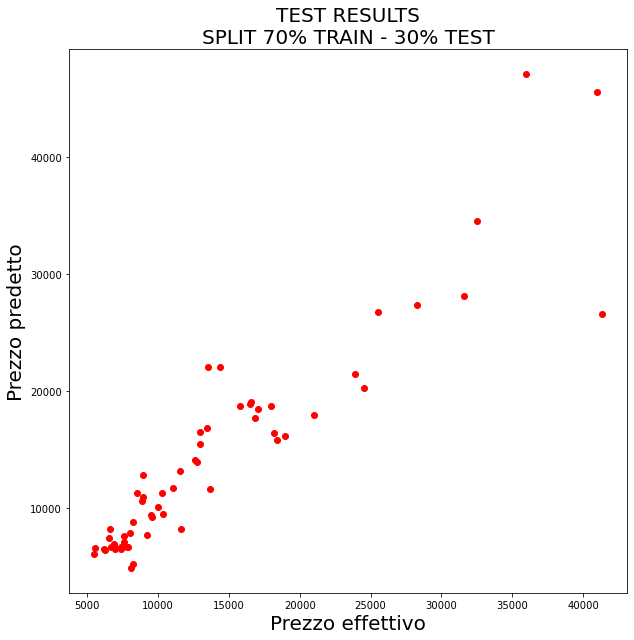

In [141]:
plt.figure(figsize=(10,10))
plt.scatter(x = y_dataset, y = predizione, c='red') 
plt.title("TEST RESULTS\nSPLIT 70% TRAIN - 30% TEST", fontsize=20)
plt.xlabel("Prezzo effettivo", fontsize=20)
plt.ylabel("Prezzo predetto", fontsize=20)
plt.show()

### Cross validazione

Funzione per la cross validazione

In [142]:
def crossValidation(alpha, tolerance, n_folds, dataset):
    foldDimension = dataset.shape[0] // n_folds
    finalTheta = 0
    bestRMSE = 0
    somma_r2 = 0
    somma_rmse = 0
    somma_mae= 0

    for i in range(n_folds):
        startFold = i * foldDimension
        endFold = (i+1) * foldDimension

        # per il training set "tolgo" i fold fra startFold e endFold
        # training_set è un nuovo dataframe con le righe indicate dall'intervallo [startFold : endFold] eliminate e con un nuovo indice sequenziale
        training_set = dataset.drop(dataset.index[startFold : endFold]).reset_index(drop = True)
        x_training = training_set.drop('price', axis = 1).values
        y_training = training_set['price'].values

        # uso i fold tolti per il test set
        test_set = dataset[startFold : endFold].reset_index(drop = True)
        x_test = test_set.drop('price', axis = 1).values
        y_test = test_set['price'].values

        m = len(training_set)

        # genero un array di theta casuali inizializzati in base ai valori massimi e minimi dei dati 
        # target (y_training) e in base al numero di features nella matrice delle features (x_training)
        theta = np.random.uniform(-(np.max(y_training)), np.max(y_training), size=x_training.shape[1])
        thetaTrain = gradientDescent(alpha, tolerance, theta, x_training, y_training, m)

        prediction = predictions(x_test=x_test, theta=thetaTrain)

        r2, mae, rmse = modelEvaluation(prediction=prediction, target=y_test)

        if i == 0:
            finalTheta = thetaTrain
            bestRMSE = rmse
        elif rmse < bestRMSE:
            finalTheta = thetaTrain
            bestRMSE = rmse

        somma_mae = somma_mae + mae
        somma_r2 = somma_r2 + r2
        somma_rmse = somma_rmse + rmse

    # dividendo le somme per nfolds si ottiene una media delle misure di valutazione su tutti i fold, 
    # rende le stime più rappresentative delle prestazioni del modello sull'intero dataset
    sum_r2_mean = somma_r2/n_folds
    sum_rmse_mean = somma_rmse/n_folds
    sum_mae_mean = somma_mae/n_folds

    return finalTheta, sum_r2_mean, sum_mae_mean, sum_rmse_mean

altra versione della corss validazione (da testare)

In [148]:
def crossValidationV2(alpha, tolerance, n_folds, dataset):
    foldDimension = dataset.shape[0] // n_folds
    finalTheta = None
    bestRMSE = float('inf')
    sum_r2_mean = 0
    sum_rmse_mean = 0
    sum_mae_mean = 0

    for i in range(n_folds):
        startFold = i * foldDimension
        endFold = (i + 1) * foldDimension

        training_set = dataset.drop(index=range(startFold, endFold)).reset_index(drop=True)
        x_training = training_set.drop('price', axis=1).values
        y_training = training_set['price'].values

        test_set = dataset.loc[startFold:endFold-1].reset_index(drop=True)
        x_test = test_set.drop('price', axis=1).values
        y_test = test_set['price'].values

        m = len(training_set)
        theta = np.random.uniform(-np.max(y_training), np.max(y_training), size=x_training.shape[1])
        thetaTrain = gradientDescent(alpha, tolerance, theta, x_training, y_training, m)

        prediction = predictions(x_test, thetaTrain)
        r2, mae, rmse = modelEvaluation(prediction, y_test)

        if rmse < bestRMSE:
            bestRMSE = rmse
            finalTheta = thetaTrain

        sum_mae_mean += mae
        sum_r2_mean += r2
        sum_rmse_mean += rmse

    avg_mae = sum_mae_mean / n_folds
    avg_r2 = sum_r2_mean / n_folds
    avg_rmse = sum_rmse_mean / n_folds

    return finalTheta, avg_r2, avg_mae, avg_rmse


### Test con cross validazione

Carico il dataset

In [150]:
dataset = pd.read_csv('cars_numeric.csv')

# è meglio mischaire le righe del dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# bisogna inserire la colonna di bias
dataset.insert(0, 'bias', np.ones(dataset.shape[0]), True)

In [151]:
print('\n******* TEST CON CROSS-VALIDAZIONE *******')
alpha = 0.01
tolerance = 0.00000001
(finalTheta, r2, mae, rmse) = crossValidation(alpha, tolerance, 10, dataset)

printLinRegFunction(theta=finalTheta, data=dataset)
printEvaluationResults(r2=r2, mae=mae, rmse=rmse)


******* TEST CON CROSS-VALIDAZIONE *******
########## MODELLO ##########

LGND: price = Theta * feature

price = 
	13185.33884 * bias +
	194.34995 * symboling +
	-464.61559 * normalized-losses +
	-1068.89491 * make +
	2863.27709 * fuel-type +
	788.81714 * aspiration +
	37.61788 * num-of-doors +
	-231.19123 * body-style +
	-670.68624 * drive-wheels +
	1429.12723 * engine-location +
	424.80253 * wheel-base +
	187.32459 * length +
	838.13768 * width +
	300.90602 * height +
	1185.10044 * curb-weight +
	57.60723 * engine-type +
	1284.19179 * num-of-cylinders +
	4083.79844 * engine-size +
	-997.33495 * fuel-system +
	-151.67563 * bore +
	-738.50086 * stroke +
	-1868.02657 * compression-ratio +
	-40.35968 * horsepower +
	915.27742 * peak-rpm +
	-1432.80111 * city-mpg +
	1717.79961 * highway-mpg +

########## RISULTATI VALUTAZIONE ##########

R2 = 0.85136
Mean absolute error = 2094.67976
Root Mean Squared Error = 2811.50312


In [152]:
print('\n******* TEST CON CROSS-VALIDAZIONE V2*******')
alpha = 0.01
tolerance = 0.00000001
(finalTheta, r2, mae, rmse) = crossValidationV2(alpha, tolerance, 10, dataset)

printLinRegFunction(theta=finalTheta, data=dataset)
printEvaluationResults(r2=r2, mae=mae, rmse=rmse)


******* TEST CON CROSS-VALIDAZIONE V2*******
########## MODELLO ##########

LGND: price = Theta * feature

price = 
	13185.33884 * bias +
	194.34992 * symboling +
	-464.61548 * normalized-losses +
	-1068.89499 * make +
	2863.27355 * fuel-type +
	788.81743 * aspiration +
	37.61786 * num-of-doors +
	-231.19129 * body-style +
	-670.68616 * drive-wheels +
	1429.12726 * engine-location +
	424.80269 * wheel-base +
	187.32451 * length +
	838.13756 * width +
	300.90613 * height +
	1185.10052 * curb-weight +
	57.60728 * engine-type +
	1284.19175 * num-of-cylinders +
	4083.79852 * engine-size +
	-997.33479 * fuel-system +
	-151.67555 * bore +
	-738.50074 * stroke +
	-1868.0233 * compression-ratio +
	-40.35982 * horsepower +
	915.27728 * peak-rpm +
	-1432.80144 * city-mpg +
	1717.79975 * highway-mpg +

########## RISULTATI VALUTAZIONE ##########

R2 = 0.85136
Mean absolute error = 2094.68029
Root Mean Squared Error = 2811.5036
